# Dataset

In [12]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["rrc06"], # rrc06: at Otemachi, Japan 
})

dataset.setPeriodsOfInterests([
    {
    "name": "GoogleLeak",
    "label": "anomaly",
    "start_time": utils.getTimestamp(2017, 8, 25, 3, 0, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2017, 8, 25, 4, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 5m 47s


# Statistical features extraction

In [13]:
from BML.transform import DatasetTransformation

# features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 5s


<Axes: >

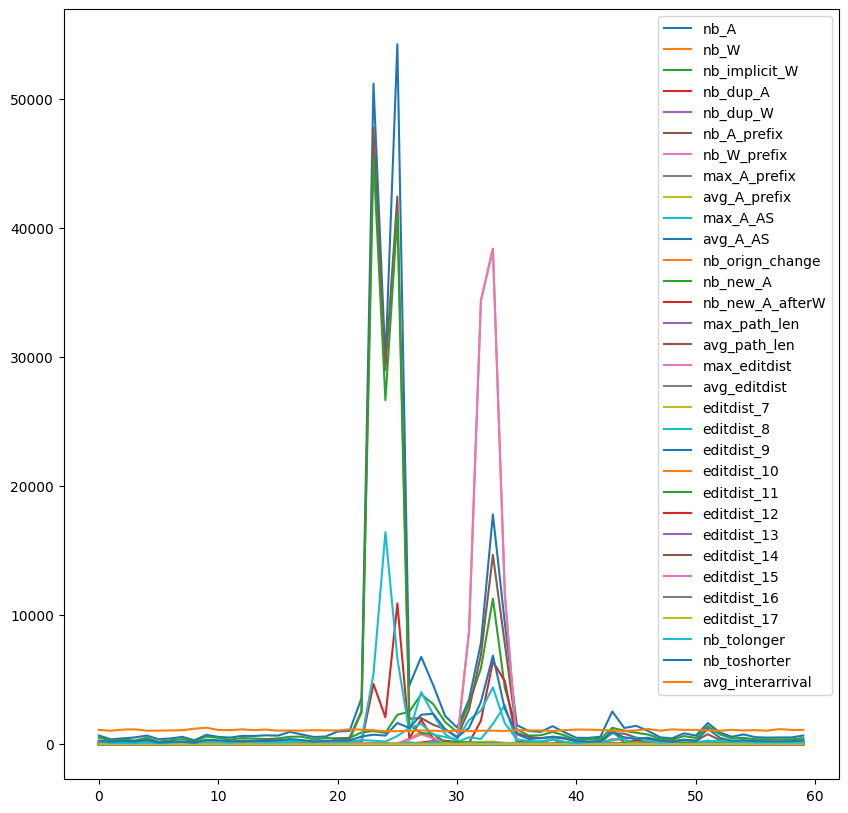

In [14]:
import pandas as pd 
data = pd.read_json(folder+"anomaly/GoogleLeak/transform/Features/Features_1.json")
data.plot(figsize=(10,10))

# Graph features extraction

In [15]:
# graph features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "GraphFeatures")

datTran.setParams({
        "global":{
            "Period": 10,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 7s


<Axes: >

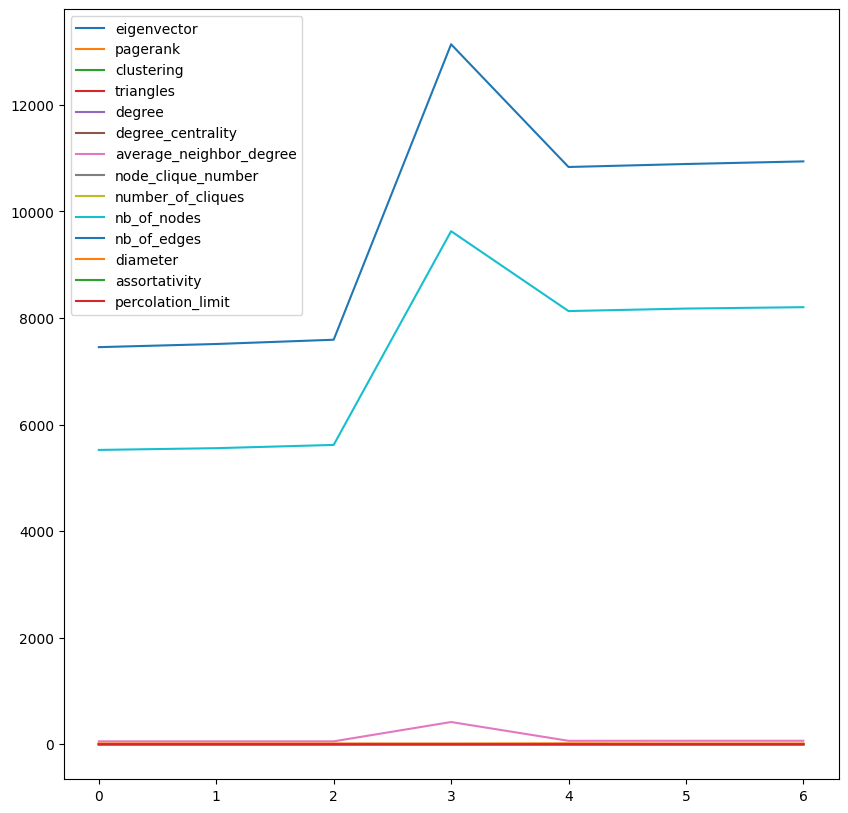

In [17]:
import pandas as pd 
data = pd.read_json(folder+"/anomaly/GoogleLeak/transform/GraphFeatures/GraphFeatures_10.json")
data.plot(figsize=(10,10))

# Custom data transformation

In [18]:
from BML.transform import DatasetTransformation
import os
import random

# Initialize the DatasetTransformation for hijack analysis
datTran = DatasetTransformation(folder, "BML.transform", "HijackLabel")

# Set transformation parameters (if any specific parameters are required for hijackAnalyze.py)
datTran.setParams({
    "global": {
        "Period": 1,  # Example parameter, modify as needed for hijackAnalyze.py
    }
})

# Run the data transformation
utils.runJobs(datTran.getJobs(), folder + "transform_jobs")

################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 4s


<Axes: >

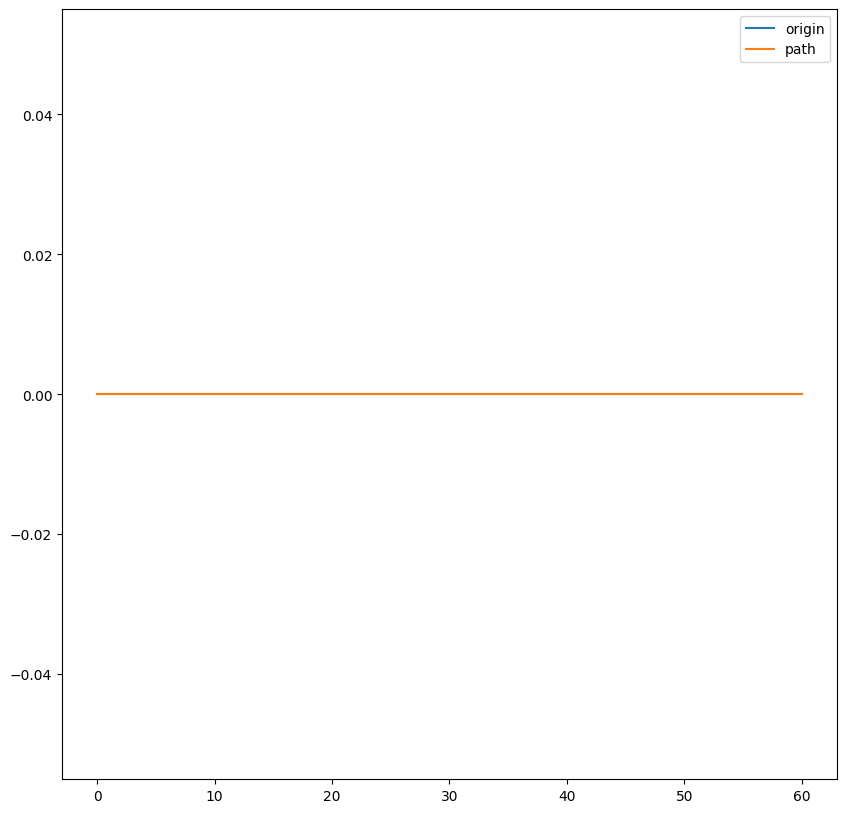

In [20]:
import pandas as pd 
data = pd.read_json(folder+"/anomaly/GoogleLeak/transform/HijackLabel/HijackLabel_1.json")
data.plot(figsize=(10,10))